In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.inspection import permutation_importance

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import (load_config, seed_everything, pairwise_comparison, volcano_plot, get_feature_importance, make_boxplot_for_features)

In [2]:
# for reproducibility
seed_everything(42)

# config file
config = load_config("../configs/config.yaml")

# Set Seaborn style
sns.set(style=config['sns_params']['style'],
        palette=config['sns_params']['palette'],
        font_scale=config['sns_params']['font_scale'])

# Set Matplotlib parameters
plt.rcParams.update(config['plt_params'])

load the normalized data for selected features/samples:

In [3]:
data_mat = pd.read_csv('../results/misc/data_mat_filter_norm.csv')
data_mat.drop(['sample'], axis=1, inplace=True)
data_mat.shape

(78, 173)

### Statistical approach

perform pairsie comparison using Wilcoxon test, also calculate fold change (FC)

In [4]:
# pairwise comparisons
french_lmu = pairwise_comparison(data_mat, class1='LMU', class2='French')
french_dunn = pairwise_comparison(data_mat, class1='Dunn', class2='French')
lmu_dunn = pairwise_comparison(data_mat, class1='Dunn', class2='LMU')

# concat all
all_pair_res = pd.concat([french_lmu, french_dunn, lmu_dunn], axis=0)

# adjust pvalues function
all_pair_res['padj'] = all_pair_res['p_value'] * len(all_pair_res)
all_pair_res['padj'] = all_pair_res['padj'].clip(upper=1)
all_pair_res.head()


,feature,p_value,log2FC,Group,padj
35,FT-221,9.432896e-36,0.746375,French_vs_LMU,4.867374e-33
157,FT-050,4.445883e-43,0.733584,French_vs_LMU,2.294075e-40
136,FT-043,2.018778e-38,0.728498,French_vs_LMU,1.041689e-35
169,FT-046,2.724118e-42,0.704974,French_vs_LMU,1.405645e-39
167,FT-232,7.288421e-24,0.440643,French_vs_LMU,3.760825e-21


true pvalue distribution should be skewed toward left:

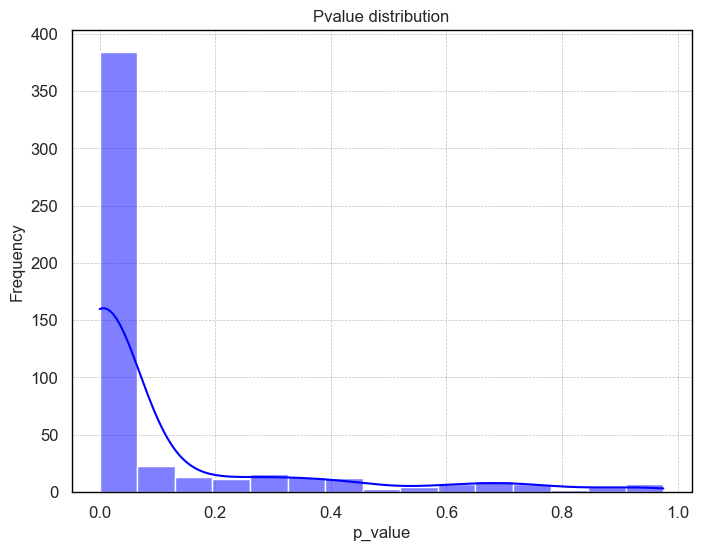

In [5]:
# pvalue distribution
plt.figure()
sns.histplot(all_pair_res['p_value'], bins=15, kde=True, color='blue')
plt.ylabel('Frequency')
plt.title('Pvalue distribution')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.savefig(f"{config['paths']['figures_dir']}/pval_distribution.png")
plt.show()

volcano plot (logFC_threshold = 2):

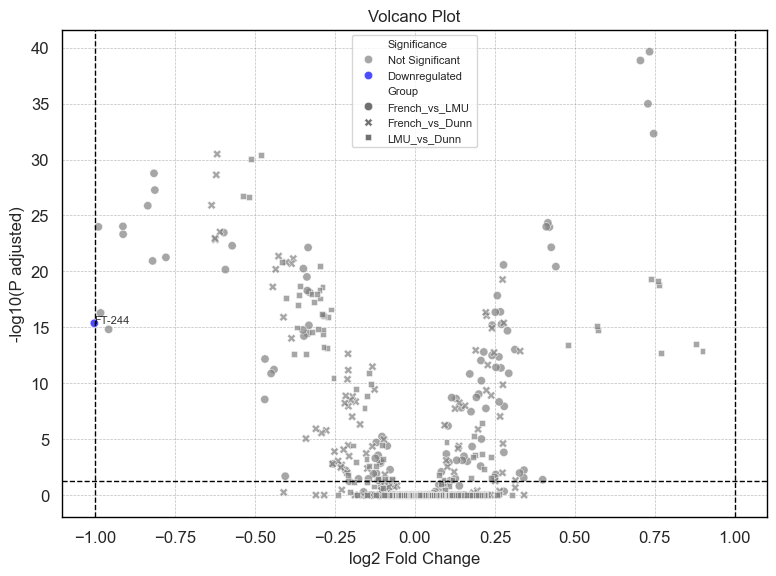

In [6]:
fc_threshold = 1

volcano_plot(
     all_pair_res.copy(), log2fc_col='log2FC', padj_col='padj', feature_col='feature',
     group_col='Group', significance_threshold=0.05, fc_threshold=fc_threshold,
     save_path=f"{config['paths']['figures_dir']}/volcano_plot_fcThreshold1.png"
 )


volcano plot (logFC_threshold = 1.5):

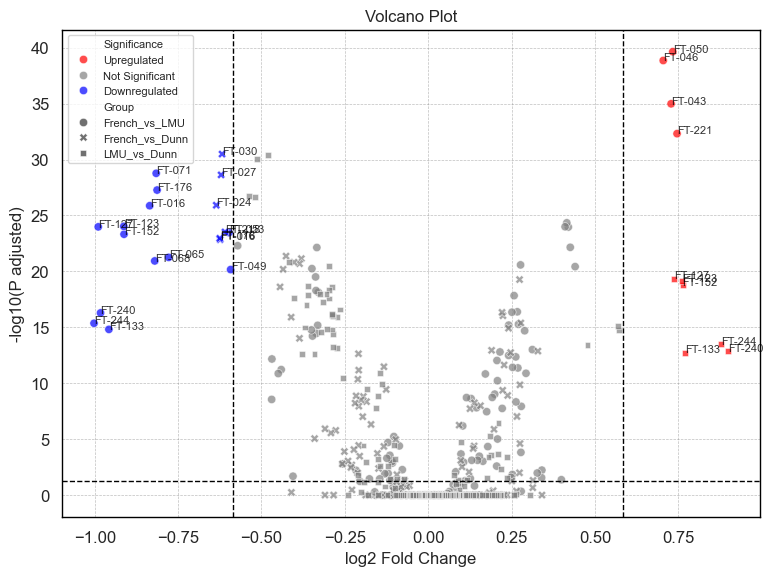

In [7]:
fc_threshold=np.log2(1.5) # threshold = 0.585

volcano_plot(
     all_pair_res.copy(), log2fc_col='log2FC', padj_col='padj', feature_col='feature',
     group_col='Group', significance_threshold=0.05, fc_threshold=fc_threshold,
     save_path=f"{config['paths']['figures_dir']}/volcano_plot_fcThreshold0.585.png"
 )

Look at the distribution of significantly upregulated or downregulated features across classes:

In [8]:
conditions = [
    (all_pair_res['padj'] < 0.05) & (all_pair_res['log2FC'] > fc_threshold),
    (all_pair_res['padj'] < 0.05) & (all_pair_res['log2FC'] < -fc_threshold),
]
sig_labels = ['Upregulated', 'Downregulated']
all_pair_res['Significance'] = np.select(conditions, sig_labels, default='Not Significant')

stat_selected_features = all_pair_res[(all_pair_res['Significance'].isin(sig_labels))]['feature'].unique().tolist()
stat_selected_features_french_lmu = all_pair_res[(all_pair_res['Significance'].isin(sig_labels)) & (all_pair_res['Group']=='French_vs_LMU')]['feature'].unique().tolist()
stat_selected_features_french_dunn = all_pair_res[(all_pair_res['Significance'].isin(sig_labels)) & (all_pair_res['Group']=='French_vs_Dunn')]['feature'].unique().tolist()
stat_selected_features_lmu_dunn = all_pair_res[(all_pair_res['Significance'].isin(sig_labels)) & (all_pair_res['Group']=='LMU_vs_Dunn')]['feature'].unique().tolist()

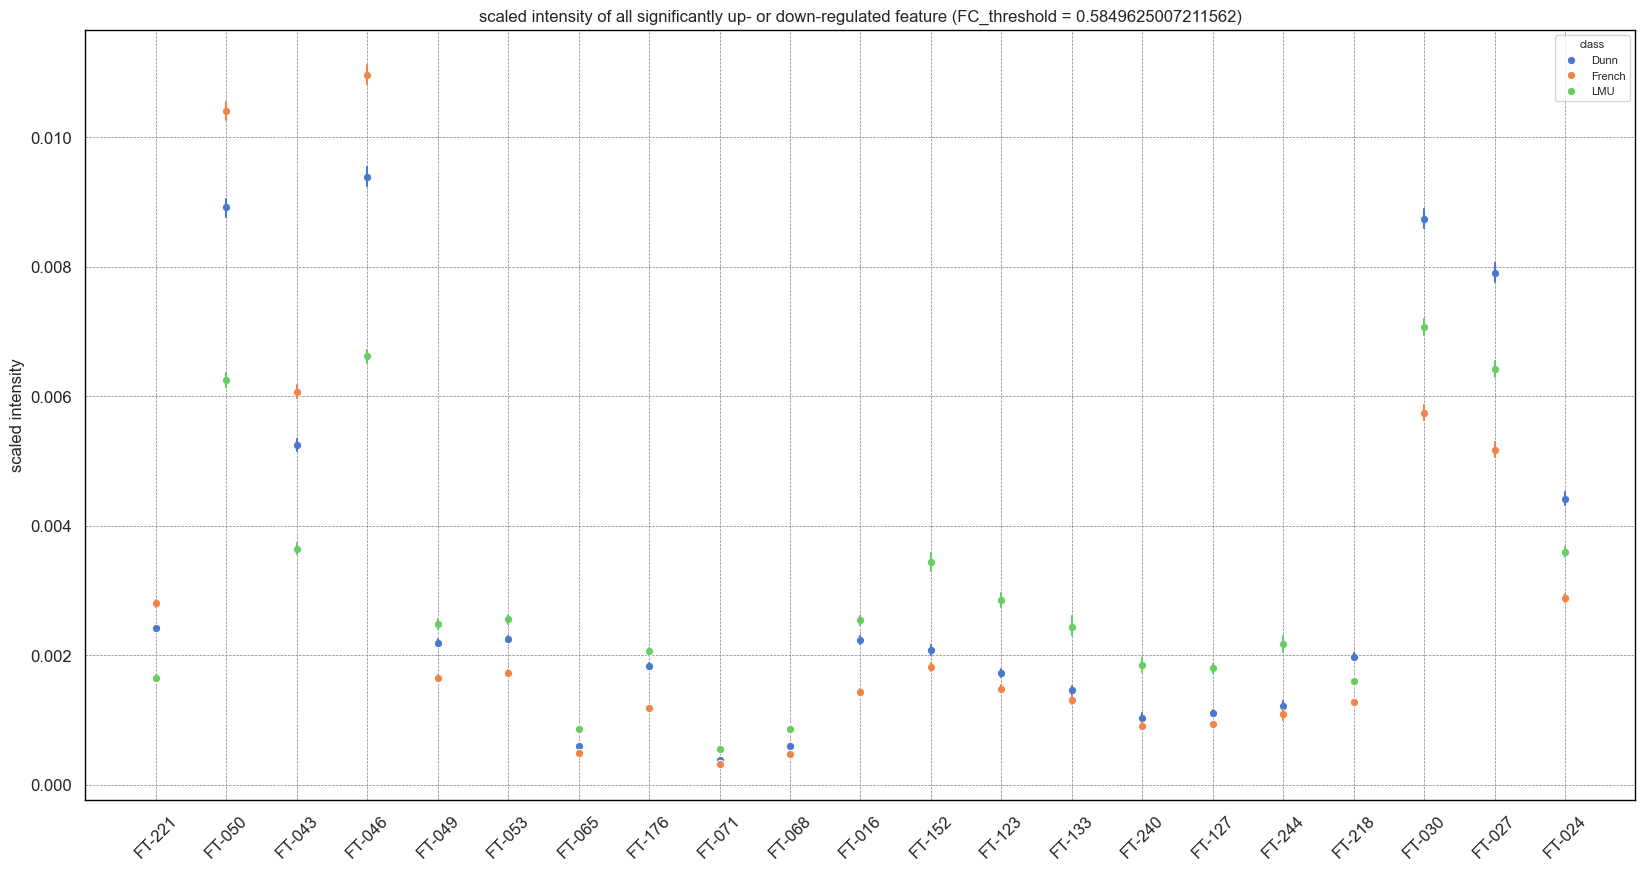

In [9]:
plt.figure(figsize=(20, 10))
sns.lineplot(data_mat[stat_selected_features + ['class']].melt(id_vars='class', var_name='feature', value_name='intensity'),\
             hue='class', x='feature', y='intensity', linestyle='', err_style='bars', marker='o')
plt.xlabel(None)
plt.xticks(rotation=45)
plt.ylabel('scaled intensity')
plt.title(f'scaled intensity of all significantly up- or down-regulated feature (FC_threshold = {fc_threshold})')
plt.savefig(f"{config['paths']['figures_dir']}/stat_significant_features_intensities.png")
plt.show()

### ML method

#### Using the up- or down-regulated feature in each pairwise comparison, a random forest is trained and feature importance is calculated:

1) French vs LMU

best_params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 3}
********************
Balanced Accuracy: 1.000
********************
Classification report :
               precision    recall  f1-score   support

      French       1.00      1.00      1.00         6
         LMU       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



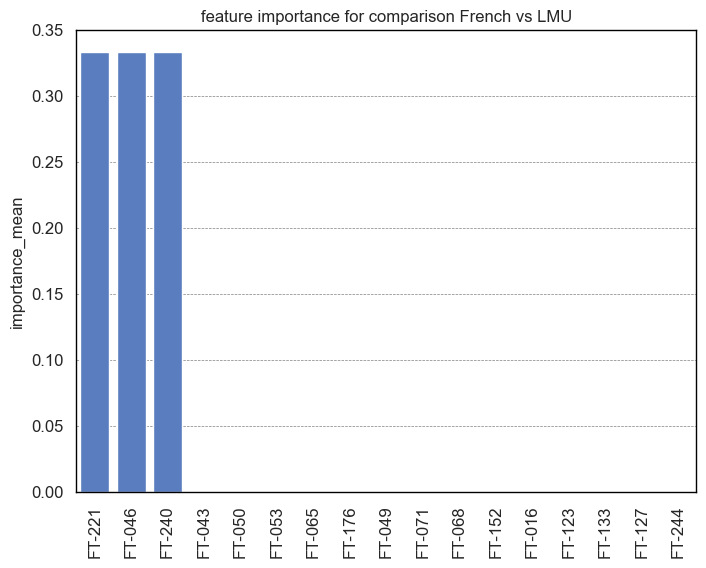

In [10]:
importance_df_french_lmu = get_feature_importance(data_mat, stat_selected_features_french_lmu, group1='French', group2='LMU', save=True)

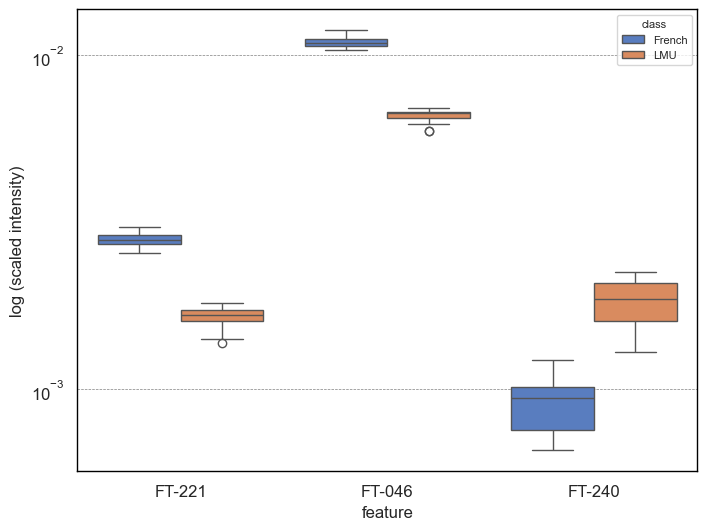

In [11]:
make_boxplot_for_features(data_mat, importance_df_french_lmu, group1='French', group2='LMU', log_scale=True, save=True)

2) French vs Dunn

best_params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 3}
********************
Balanced Accuracy: 1.000
********************
Classification report :
               precision    recall  f1-score   support

      French       1.00      1.00      1.00         6
        Dunn       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



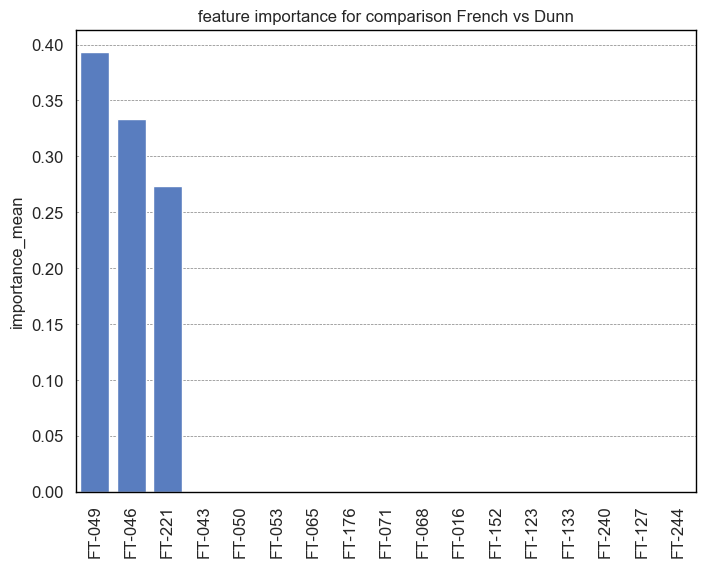

In [12]:
importance_df_french_dunn = get_feature_importance(data_mat, stat_selected_features_french_lmu, group1='French', group2='Dunn', save=True)

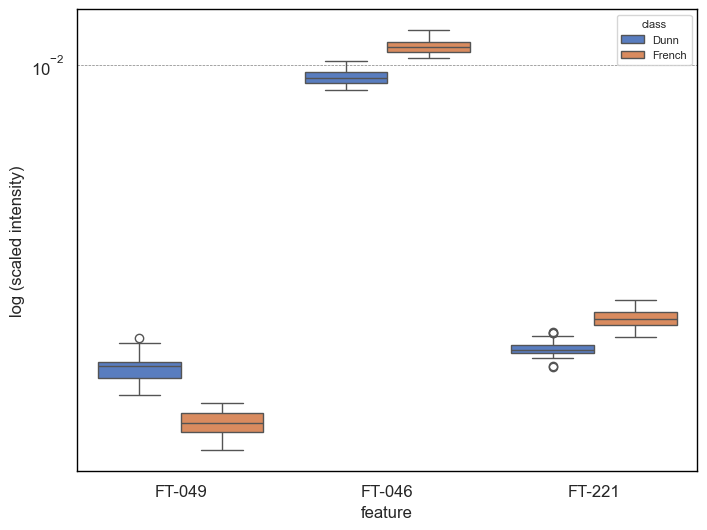

In [13]:
make_boxplot_for_features(data_mat, importance_df_french_dunn, group1='French', group2='Dunn', log_scale=True, save=True)

3) LMU vs Dunn

best_params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 3}
********************
Balanced Accuracy: 1.000
********************
Classification report :
               precision    recall  f1-score   support

         LMU       1.00      1.00      1.00         6
        Dunn       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



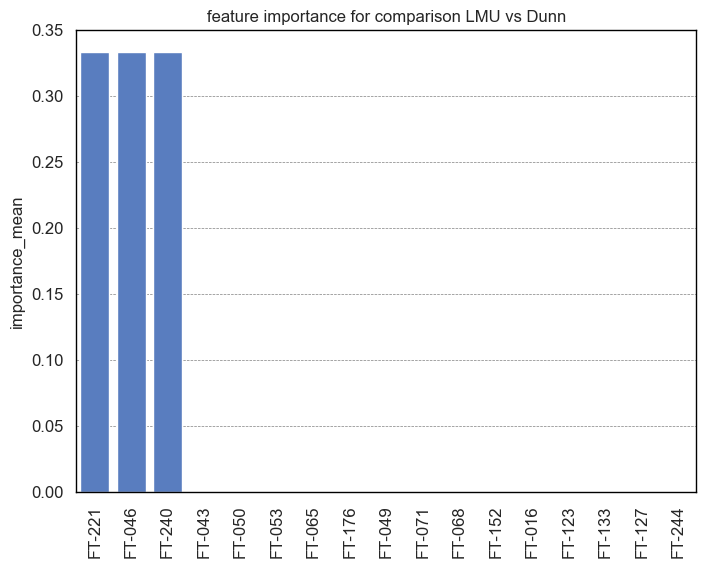

In [14]:
importance_df_lmu_dunn = get_feature_importance(data_mat, stat_selected_features_french_lmu, group1='LMU', group2='Dunn', save=True)

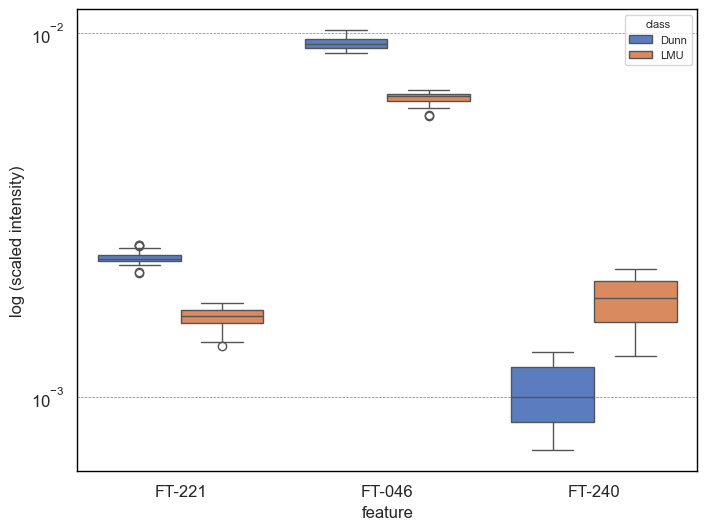

In [15]:
make_boxplot_for_features(data_mat, importance_df_lmu_dunn, group1='LMU', group2='Dunn', log_scale=True, save=True)